**Introduction to Applications of Quantum Computing to Quan-
tum Chemistry**

2.   **Ground state energy for molecule and spin system with Variational
Quantum Algorithms and Trotterization.**

Variational Quantum Algorithms (VQAs) are a class of hybrid quantum-classical algorithms. These algorithms leverage quantum circuits to accelerate computations while utilizing a classical optimizer to iteratively adjust the parameters of the circuit, seeking to minimize a cost function and ultimately find the correct solution.

(a) The calculation of molecular properties is crucial in scientific and technological fields, such as chemistry and the pharmaceutical industry. In particular, the ground state energy of a molecule provides valuable insights into its properties, including stability and reactivity.

You must implement a function in Pennylane that simulates the Variational Quantum Eigensolver (VQE). This function should take as input a six-entry array of floating-point numbers, representing the x, y and z coordinates of two hydrogen atoms. The first three entries correspond to the coordinates of the first hydrogen atom, and the remaining three entries represent the coordinates of the second hydrogen atom. The function should return the ground state energy of the molecule. Also explain why the Pauli-Z is necessary in Jordan-Wigner transformation.

**Observation: Explicitly define the STO-3G basis function set, multiplicity=1, charge=0 and Jordan-Wigner mapping in the code.**

(b) Consider a spin chain consisting of N spin-$\frac{1}{2}$
particles, where each spin can point either in the positive or negative z-direction. Additionally, an external magnetic field is applied to the system.

This quantum system is described by the Transverse Ising Hamiltonian. For a closed spin chain with a transverse magnetic field of intensity h, the Hamiltonian is:

$$ H = -\sum_{i=1}^N Z_i \otimes Z_{i+1} -h\sum_{n=1}^NX_i$$
where $Z_i$ and $X_i$ are the Pauli-Z and Pauli-X operators acting on the $i-th$ spin site, respectively. In a closed chain, the site $N + 1$ is identified with the first site.

You must implement a variational quantum algorithm in Pennylane that, for a given value of the transverse magnetic field h, computes the ground state energy of the spin chain with N = 4 sites. The magnetic field intensity h should be passed as an input to the algorithm.

(c) The total energy of a quantum system is represented by operator $H$. We know
that an initial quantum state $|\psi⟩$ evolves over time through the action of the evolution operator U, defined as


In [ ]:
!pip install pennylane

In [1]:


import pennylane as qml
from pennylane import numpy as pnp
from random import choice

In [4]:
# Question (a)

def get_the_ground_state():
  # Collect the coordinates
  coord_1 = list(map(float, input('Enter the coordinates of the first H as x y z: ').split()))
  coord_2 = list(map(float, input('Enter the coordinates of the second H as x y z: ').split()))

  # Define the symbols and the coordinates
  symbols = ["H", "H"]
  coordinates = pnp.array([coord_1, coord_2])

  # Create the molecule
  molecule = qml.qchem.Molecule(symbols, coordinates, charge = 0, mult = 1, basis_name='sto-3g') # Creating the molecule with the exercise
  H, qubits = qml.qchem.molecular_hamiltonian(molecule, mapping='jordan_wigner')

  # Print out the Hamiltonian just to check if it's all right
  print(f"Hamiltonian: {H}")

  # Connecting  with the device
  dev = qml.device("default.qubit", wires = qubits)

  # Creating the cost_function
  @qml.qnode(dev)
  def cost_function(params): 
    qml.BasisState(pnp.array([1, 1, 0, 0]), wires = range(qubits)) # Creating the basis state
    qml.DoubleExcitation(params, wires = [0, 1, 2, 3]) # Why i have to use Double Exctations?

    return qml.expval(H)

  # Drawing the circuit
  qml.draw_mpl(cost_function)(1); #What is this pnp.array?

  # Choose an optimizer
  opt = qml.GradientDescentOptimizer(stepsize = 0.4)

  # Initial guess parameters
  theta = pnp.array(0.20885146442480412, requires_grad=True)

  # Programing the optimzation routine
  energy = [cost_function(theta)] # Store the values of the cost function
  angle = [theta] # Store the values of the circuit parameter

  max_iterations = 40 # Maximum number of calls to the optimizer
  conv_tol = 1e-06 # Convergence threshold to stop our optimization procedure

  for n in range(max_iterations):
    theta,prev_energy=opt.step_and_cost(cost_function,theta)
    energy.append(cost_function(theta))
    angle.append(theta)
    conv=pnp.abs(energy[-1]-prev_energy)

    if conv<=conv_tol:
        break

  # Print out the value of the ground state energy
  print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")

  return ''

# Part B

In [3]:
h = float(input("Enter the extenal magnetic field: "))

## Creating the Hamiltonian

In [19]:
# Creating the Hamiltonian

coefs = [-1, -h]
ops = [sum(qml.PauliZ(i) @ qml.PauliZ(i+1) if i !=3 else qml.PauliZ(i)@ qml.PauliZ(0) for i in range(4)) , sum(qml.PauliX(i) for i in range(4))]

# Number of Qubits 
N = 4 

# Hamiltonian
H = qml.Hamiltonian(coefs, ops)

# Printing the Hamltonian
print(f"\n\n\nThe Hamiltonian is given by: {H}\n\n\n")





The Hamiltonian is given by: -1 * (Z(0) @ Z(1) + Z(1) @ Z(2) + Z(2) @ Z(3) + Z(3) @ Z(0)) + -5.0 * (X(0) + X(1) + X(2) + X(3))





# Choosing the Ansatz(VERIFICAR COM CALMA ISSO)

We must find which ansatz is capable of satisfying the problem.

*For example:*
Is the doubleexcitation function capable of correcly solving this problem?

Notice that 
$$ H = -\sum_{i=1}^N Z_i \otimes Z_{i+1} -h\sum_{n=1}^NX_i$$

This is invariant to rotations in $SO(2)$ involving $\{|0011 \rangle,|1100 \rangle \}$. 

So in this case, we need to perform rotations in $SO(2)$ involving the first and third qubits(or equivalently, as this is a closed chain) the second or fourth qubit.

## Single Excitation

As was shown before, we can implement an SingleExcitation in qubits 1 and 3 to change the value of our H(as to minimize it)


(<Figure size 500x500 with 1 Axes>, <Axes: >)

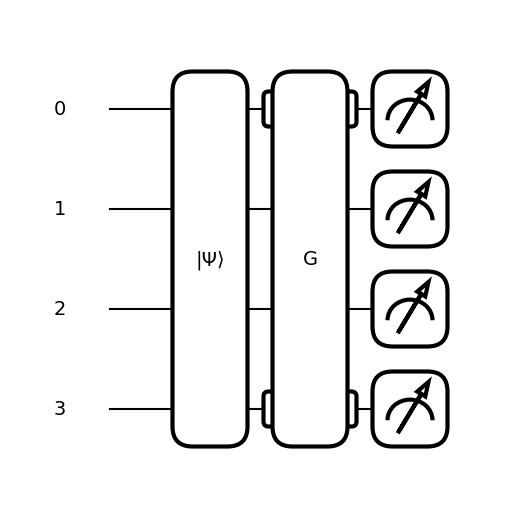

In [46]:
# Creating the circuit
dev = qml.device("default.qubit", wires=N)


@qml.qnode(dev)
def cost_function(params):
  qml.BasisState(pnp.array([1, 1, 0, 0]), wires = [i for i in range(N)])
  qml.SingleExcitation(params,wires = [0,3])

  return qml.expval(H)

# Drawing the circuit
qml.draw_mpl(cost_function)(1)


In [81]:
# Choose an optimizer
opt = qml.GradientDescentOptimizer(stepsize = 0.4)

# Initial guess parameters
thetazero = 0.5
theta = pnp.array(thetazero, requires_grad=True)

# Programing the optimzation routine
energy = [cost_function(theta)] # Store the values of the cost function
angle = [theta] # Store the values of the circuit parameter

max_iterations = 40 # Maximum number of calls to the optimizer
conv_tol = 1e-06 # Convergence threshold to stop our optimization procedure

for n in range(max_iterations):
  theta,prev_energy=opt.step_and_cost(cost_function,theta)
  energy.append(cost_function(theta))
  angle.append(theta)
  conv=pnp.abs(energy[-1]-prev_energy)
  if n%2==0:
    print(f"step = {n}, Energy: {energy}")
  if conv<=conv_tol:
      break

# Print out the value of the ground state energy
print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")

step = 0, Energy: [tensor(0.24483488, requires_grad=True), tensor(0.01354751, requires_grad=True)]
step = 2, Energy: [tensor(0.24483488, requires_grad=True), tensor(0.01354751, requires_grad=True), tensor(0.00055234, requires_grad=True), tensor(2.21106972e-05, requires_grad=True)]
step = 4, Energy: [tensor(0.24483488, requires_grad=True), tensor(0.01354751, requires_grad=True), tensor(0.00055234, requires_grad=True), tensor(2.21106972e-05, requires_grad=True), tensor(8.84455525e-07, requires_grad=True), tensor(3.53782657e-08, requires_grad=True)]

Final value of the ground-state energy = 0.00000004 Ha


In [74]:
cost_function(0.3)

tensor(0.08932702, requires_grad=True)

In [51]:
H

(
    -1 * (Z(0) @ Z(1)
  + Z(1) @ Z(2)
  + Z(2) @ Z(3)
  + Z(3) @ Z(0))
  + -5.0 * (X(0)
  + X(1)
  + X(2)
  + X(3))
)